# 3.5 SmoothGrad

## Tensorflow Walkthrough

### 1. Import Dependencies

In [1]:
import os

from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

from models.models_3_5 import MNIST_CNN
from utils import pixel_range

%matplotlib inline

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
images = mnist.train.images
labels = mnist.train.labels

logdir = './tf_logs/3_5_SG/'
ckptdir = logdir + 'model'

if not os.path.exists(logdir):
    os.mkdir(logdir)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


### 2. Building Graph

In [2]:
with tf.name_scope('Classifier'):

    # Initialize neural network
    DNN = MNIST_CNN('CNN')

    # Setup training process
    X = tf.placeholder(tf.float32, [None, 784], name='X')
    Y = tf.placeholder(tf.float32, [None, 10], name='Y')
    training = tf.placeholder_with_default(False, shape=[], name='training')
    activations = DNN(X, training)
    
    tf.add_to_collection('placeholders', training)
    tf.add_to_collection('placeholders', X)

    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=activations[-1], labels=Y))

    optimizer = tf.train.AdamOptimizer().minimize(cost, var_list=DNN.vars)

    correct_prediction = tf.equal(tf.argmax(activations[-1], 1), tf.argmax(Y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    ind = tf.placeholder(tf.int32, shape=[], name='index')
    
    tf.add_to_collection('placeholders', ind)
    
    # Generate Vanilla Grad
    grad = tf.gradients(activations[-1][:, ind], X)[0]
    
    # Generate SmoothGrad
    sample_size = tf.placeholder(tf.int32, shape=[], name='sample_size')
    sigma = tf.placeholder(tf.float32, shape=[], name='sigma')
    
    X_input1 = tf.tile(X, multiples=[sample_size, 1]) + tf.random_normal([sample_size, 784], stddev=sigma)
    X_output1 = DNN(X_input1, training, reuse=True)
    
    smoothgrad = tf.reduce_mean(tf.gradients(X_output1[-1][:, ind], X_input1)[0], axis=0)
    
    tf.add_to_collection('placeholders', sample_size)
    tf.add_to_collection('placeholders', sigma)
    
    # Generate Integrated Gradients
    steps = tf.placeholder(tf.int32, shape=[], name='steps')
        
    X_input2 = tf.tile(X, multiples=[steps, 1]) * tf.reshape(tf.linspace(0., 1., num=steps + 1)[1:], [steps, 1])
    X_output2 = DNN(X_input2, training, reuse=True)
    
    intgrad = X * tf.reduce_mean(tf.gradients(X_output2[-1][:, ind], X_input2)[0], axis=0, keep_dims=True)
    
    tf.add_to_collection('placeholders', steps)
    
    tf.add_to_collection('grads', grad)
    tf.add_to_collection('grads', smoothgrad)
    tf.add_to_collection('grads', intgrad)
    
cost_summary = tf.summary.scalar('Cost', cost)
accuray_summary = tf.summary.scalar('Accuracy', accuracy)
summary = tf.summary.merge_all()

### 3. Training Network

In [3]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

saver = tf.train.Saver()
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

# Hyper parameters
training_epochs = 15
batch_size = 100

for epoch in range(training_epochs):
    total_batch = int(mnist.train.num_examples / batch_size)
    avg_cost = 0
    avg_acc = 0
    
    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        mean = np.mean(batch_xs, axis=0, keepdims=True)
        batch_xs = batch_xs - mean
        
        _, c, a, summary_str = sess.run([optimizer, cost, accuracy, summary], feed_dict={X: batch_xs, Y: batch_ys, training: True})
        avg_cost += c / total_batch
        avg_acc += a / total_batch
        
        file_writer.add_summary(summary_str, epoch * total_batch + i)

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost), 'accuracy =', '{:.9f}'.format(avg_acc))
    
    saver.save(sess, ckptdir)

print('Accuracy:', sess.run(accuracy, feed_dict={X: mnist.test.images, Y: mnist.test.labels}))

sess.close()

Epoch: 0001 cost = 0.311481388 accuracy = 0.906363638
Epoch: 0002 cost = 0.105582403 accuracy = 0.968581827
Epoch: 0003 cost = 0.079347551 accuracy = 0.975690918
Epoch: 0004 cost = 0.065745663 accuracy = 0.980454556
Epoch: 0005 cost = 0.055103825 accuracy = 0.982563647
Epoch: 0006 cost = 0.048535820 accuracy = 0.984890919
Epoch: 0007 cost = 0.041984907 accuracy = 0.986527282
Epoch: 0008 cost = 0.039468893 accuracy = 0.987745464
Epoch: 0009 cost = 0.035014743 accuracy = 0.988545463
Epoch: 0010 cost = 0.031578903 accuracy = 0.990200009
Epoch: 0011 cost = 0.029123417 accuracy = 0.990618190
Epoch: 0012 cost = 0.027011044 accuracy = 0.991254553
Epoch: 0013 cost = 0.026021425 accuracy = 0.991727280
Epoch: 0014 cost = 0.024496022 accuracy = 0.992218189
Epoch: 0015 cost = 0.021346025 accuracy = 0.992581825
Accuracy: 0.9835


### 4. Restoring Graph

In [4]:
batch, _ = mnist.train.next_batch(100)
mean = np.mean(batch, axis=0, keepdims=True)
sample_imgs = [images[np.argmax(labels, axis=1) == i][1] - mean for i in range(10)]

tf.reset_default_graph()

sess = tf.InteractiveSession()

new_saver = tf.train.import_meta_graph(ckptdir + '.meta')
new_saver.restore(sess, tf.train.latest_checkpoint(logdir))

placeholders = tf.get_collection('placeholders')
training = placeholders[0]
X = placeholders[1]

ind = placeholders[2]

sample_size = placeholders[3]
sigma = placeholders[4]
steps = placeholders[5]

grads = tf.get_collection('grads')

grad = grads[0]
smoothgrad = grads[1]
intgrad = grads[2]

INFO:tensorflow:Restoring parameters from ./tf_logs/3_5_SG/model


### 5. Displaying Images

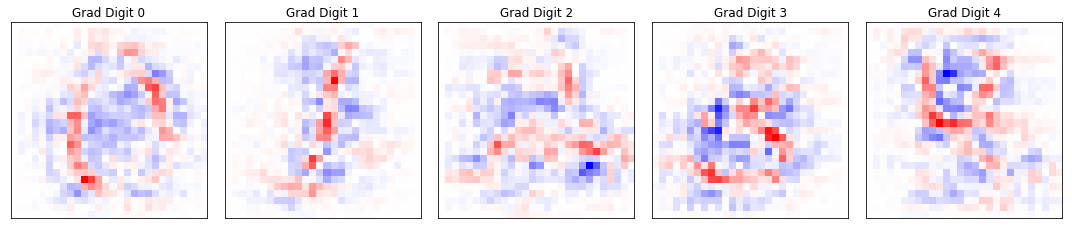

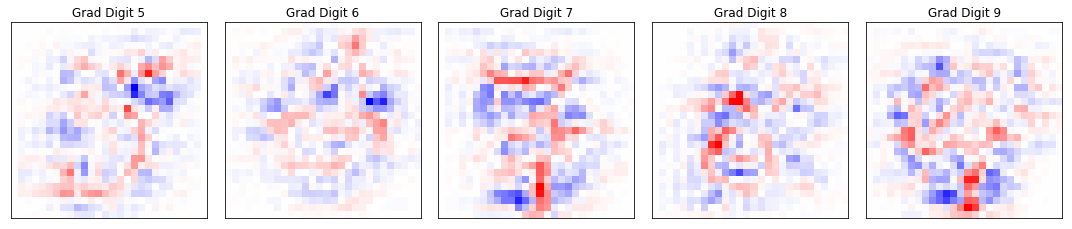

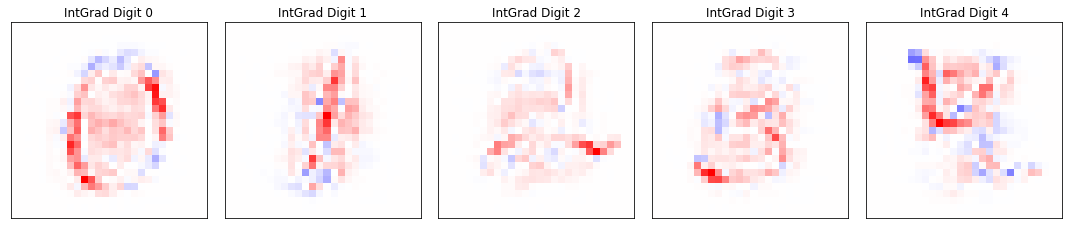

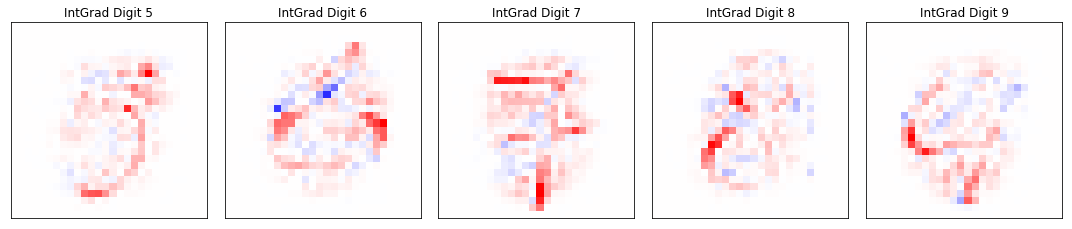

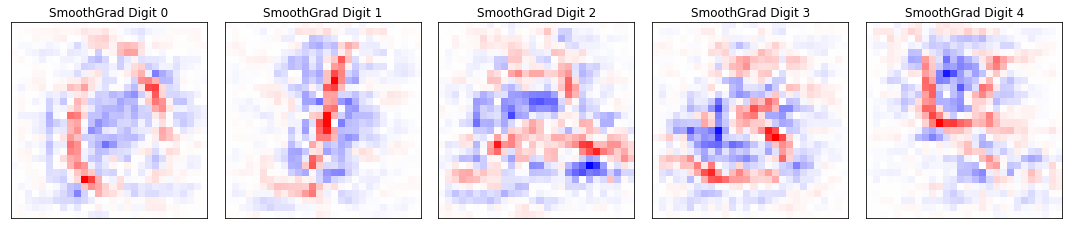

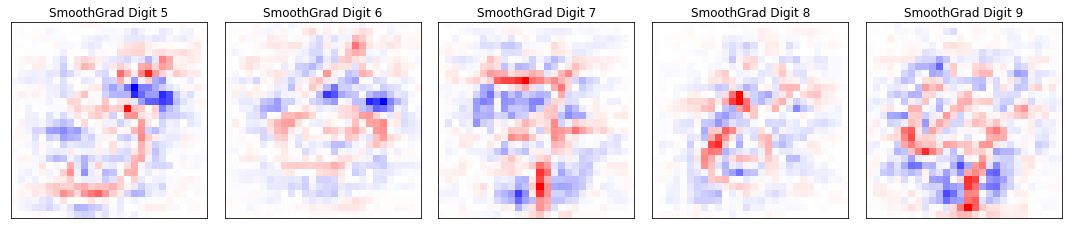

In [5]:
res11 = [sess.run(grad, feed_dict={X: sample_imgs[i].reshape(1, 784), ind: i})[0] for i in range(10)]
res12 = [sess.run(intgrad, feed_dict={X: sample_imgs[i].reshape(1, 784), steps: 50, ind: i})[0] for i in range(10)]
res13 = [sess.run(smoothgrad, feed_dict={X: sample_imgs[i].reshape(1, 784), sample_size: 100, sigma: 0.2, ind: i}) for i in range(10)]

for i in range(2):
    plt.figure(figsize=(15,15))
    for j in range(5):
        plt.subplot(2, 5, i * 5 + j + 1)
        vmin, vmax = pixel_range(res11[i * 5 + j])
        plt.imshow(res11[i * 5 + j].reshape(28,28), vmin=vmin, vmax=vmax, cmap='bwr')
        plt.xticks([])
        plt.yticks([])
        plt.title('Grad Digit {}'.format(i * 5 + j))
    plt.tight_layout()

for i in range(2):
    plt.figure(figsize=(15,15))
    for j in range(5):
        plt.subplot(2, 5, i * 5 + j + 1)
        vmin, vmax = pixel_range(res12[i * 5 + j])
        plt.imshow(res12[i * 5 + j].reshape(28,28), vmin=vmin, vmax=vmax, cmap='bwr')
        plt.xticks([])
        plt.yticks([])
        plt.title('IntGrad Digit {}'.format(i * 5 + j))
    plt.tight_layout()

for i in range(2):
    plt.figure(figsize=(15,15))
    for j in range(5):
        plt.subplot(2, 5, i * 5 + j + 1)
        vmin, vmax = pixel_range(res13[i * 5 + j])
        plt.imshow(res13[i * 5 + j].reshape(28,28), vmin=vmin, vmax=vmax, cmap='bwr')
        plt.xticks([])
        plt.yticks([])
        plt.title('SmoothGrad Digit {}'.format(i * 5 + j))
    plt.tight_layout()

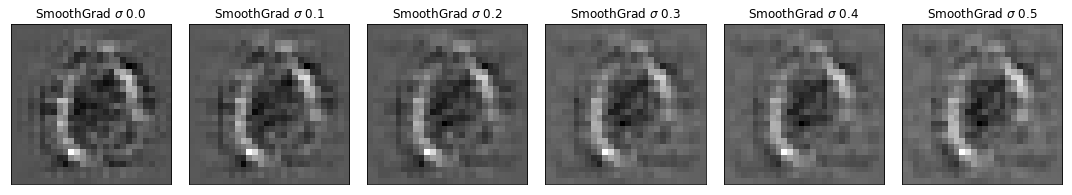

In [6]:
sigmas = np.linspace(0., 0.5, num=6)
res2 = [sess.run(smoothgrad, feed_dict={X: sample_imgs[0].reshape(1, 784), sample_size: 50, sigma: std, ind: 0}) for std in sigmas]

fig = plt.figure(figsize=(15,15))
for i in range(6):
    plt.subplot(1, 6, i + 1)
    plt.imshow(res2[i].reshape(28,28), cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.title(r'SmoothGrad $\sigma$ {:.1f}'.format(sigmas[i]))

plt.tight_layout()

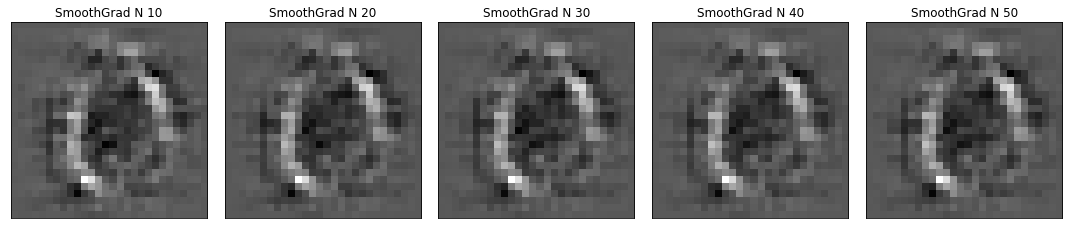

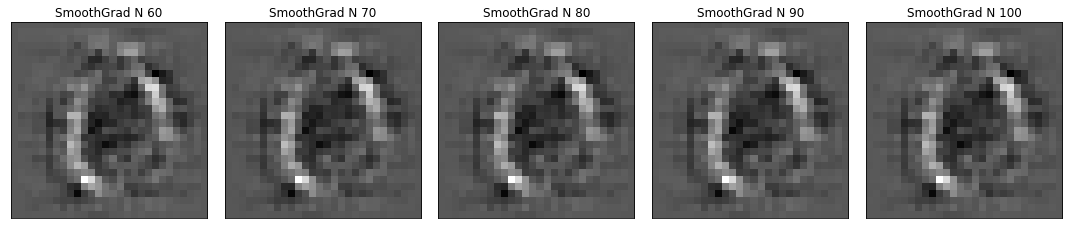

In [7]:
sample_sizes = np.linspace(10, 100, num=10, dtype=np.int32)
res3 = [sess.run(smoothgrad, feed_dict={X: sample_imgs[0].reshape(1, 784), sample_size: size, sigma: 0.1, ind: 0}) for size in sample_sizes]

for i in range(2):
    fig = plt.figure(figsize=(15,15))
    for j in range(5):
        plt.subplot(2, 5, i * 5 + j + 1)
        plt.imshow(res3[i * 5 + j].reshape(28,28), cmap='gray')
        plt.xticks([])
        plt.yticks([])
        plt.title(r'SmoothGrad N {}'.format(sample_sizes[i * 5 + j]))
    plt.tight_layout()

sess.close()